## <center> Ce notebook est editer durant le cours **Data Science : NLP** de Monsieur PELLEGRINI </center>
## Dans ce notebook j'utlise des données récuperer à partir du Allociné contenant des commentaires (avis) sur la série Netflix Squid Game

> > 

# Installation des packages manquantes

In [ ]:
!pip install dateparser

     |████████████████████████████████| 288 kB 13.4 MB/s 


In [ ]:
!pip install scattertext
!pip install spacy
!pip install nltk

     |████████████████████████████████| 7.3 MB 7.0 MB/s 
     |████████████████████████████████| 24.1 MB 1.9 MB/s 
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9309 sha256=2d2293392ae5f5a07e2ca3e6daa6d58e8929f8f3269077a8836f159b5231d271
  Stored in directory: /root/.cache/pip/wheels/cb/19/58/4e8fdd0009a7f89dbce3c18fff2e0d0fa201d5cdfd16f113b7
Successfully built flashtext
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
!python -m spacy download fr_core_news_md

     |████████████████████████████████| 88.6 MB 68.3 MB/s 
  Created wheel for fr-core-news-md: filename=fr_core_news_md-2.2.5-py3-none-any.whl size=90338488 sha256=e3da453efa1a02bb4a6eb374fc85f7091827024e1cb74b540a0a7ed78c4462c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-vjxprfwc/wheels/2e/26/ff/ce93eb966e7176ebe81e6c98209582e13e108cdd2d6d636df0
Successfully built fr-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


# Montage de mon drive

In [ ]:
from google.colab import drive
drive.mount('drive/')

Mounted at drive/


In [ ]:
import os
os.chdir('/content/drive/MyDrive/HETIC Courses/NLP') # setting the work directory

In [ ]:
!pwd # checking my working directory

/content/drive/MyDrive/HETIC Courses/NLP


In [ ]:
!ls # checking what is inside the working directory

allocine_squidgame.csv	test_mystere.xlsx  tweets_politics_2022.csv


# Importing the necessary libraries

In [ ]:
import pandas as pd
pd.set_option("max_colwidth", None)
import numpy as np
from datetime import datetime
import dateparser
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import spacy
import fr_core_news_md
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import re
from collections import Counter

In [ ]:
nltk.download(['punkt','wordnet','stopwords','averaged_perceptron_tagger'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# Import des données

In [ ]:
df = pd.read_csv('allocine_squidgame.csv')

# Main EDA and preprocessing
> english titles from now on


In [ ]:
df.head()

,Note,Description,Date,nombre_good,nombre_follow,key
0,"3,0","On s'attendait à une fin plus élaborée, clairement. Des débuts engagés de Squid Game (dénonçant l'extrême pauvreté qui touche une grande partie de la population, le désintérêt des riches face à ces prolétaires à la rue, l’appât du gain qui fait faire n'importe quoi...), sa mise en scène clinquante qui nous aguiche l’œil (les jeux comme des cours de récré mortelles, on a adoré le concept), le personnage principal (""le bon gars, le vrai"") dont a vite pitié, quelques seconds rôles attachants (Ali... On ne s'en remet pas), retrouver ""le mec de Busan"" (oui, on a tous eu le même réflexe) pour un petit rôle, un sixième épisode en apogée dramatique de la série... Squid Game a beaucoup d'idées. Mais voilà, après cette vague immense d'atouts, la série semble ne plus savoir trop quoi en faire, et retombe dès l'épisode 7 dans le train-train habituel des films de jeux sadiques où l'on pousse un groupe de personnes à s'entretuer, nous mettant sous le nez des personnages ultra-caricaturaux (le couple du truand et de la folle - élue personnage insupportable de la série -) ou si vicieux que l'on finit par se moquer éperdument de leur sort (l'ami d'enfance du héros), et surtout, une fin à la \nspoiler: \nSaw\n. On n'en revient pas d'avoir exactement le même twist, à savoir que \nspoiler: \nle créateur du jeu qui se cache parmi les ""morts"" et se rince l’œil sur le déroulé des épreuves\n... On avait déjà à demi compris ce twist, lorsque la série dévoilait trop tôt que \nspoiler: \nle vieux ne gâte pas tant qu'il veut bien le laisser paraître (à la fin de l'épisode six) et qu'il est l'un des uniques personnages dont la mort n'est pas montrée en gros plan en face caméra (cette mise en scène des scènes de tuerie nous agace, on se l'avoue), ce qui interpelle forcément\n. Une demi-surprise, donc, pour une déception totale, en revanche. On a aussi failli s'étrangler devant le spectacle navrant des \nspoiler: \n VIP masqués en animaux ""boule à facettes"" qui viennent faire des paris sur les gagnants en gloussant de plaisir à chaque mort\n, ce qui ressemble à la ligne directrice des séries ""dark"" Netflix, qui critiquent de façon balourde, n'impressionnent que les jeunes ados (et encore), et font rire les amateurs de scénario plus fins. La fin laisse aussi la porte ouverte à plusieurs saisons, Netflix oblige, ce que l'on ne trouve pas nécessaire dans l'immédiat (à voir s'il l'on parvient à nous prouver le contraire avec une super saison 2, mais on en doute...). Si suite il y a, on préfèrera voir des alliances entre joueurs comme dans les débuts de Squid Game pour déjouer les pièges, plutôt que des gens qui se tirent dans les pattes de façon mesquine et ultra-prévisible, comme dans les films d'épouvante qu'on commence à connaître. On retient surtout le héros (""vraiment, c'est un bon gars""), le pauvre Ali, quelques jeux déchirants (les billes) ou surprenants (les trois premiers), une mise en scène originale, ""le mec de Busan"" et une critique acerbe de la société. Mais les épisodes 7 à 9 commencent une chute vertigineuse (sans besoin de verre faussement trempé) vers une fin des plus faciles, vue et revue si vous connaissez une certaine saga de films d'épouvante, et assez prévisible. You Win, pour cette saison, mais Game over pour la suite.",Publiée le 2 octobre 2021,22\n\n\n10,Suivre son activité,0
1,"2,5","Encore une série très sur-côtée ! Tout est prévisible au possible, l'idée n'est pas si originale que ça et la fin est vraiment mauvaise... Cependant le jeu d'acteur et la qualité visuelle sont excellents ! On se laisse prendre au fur et à mesure des épisodes mais au final on savait très bien ce qui allait se passer quand, comment et pourquoi et c'est bien dommage. On est bien loin des gros drames coréens ! Ici c'est soft, un peu débile et souvent insupportable mais tout cela reste regardable.",Publiée le 1 octobre 2021,24\n\n\n12,Suivre son activité,1
2,"4,5","Pas fan des séries co

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Note           341 non-null    object
 1   Description    341 non-null    object
 2   Date           341 non-null    object
 3   nombre_good    341 non-null    object
 4   nombre_follow  341 non-null    object
 5   key            341 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 16.1+ KB




> > > A first look at the data I need to transform the **Date** column into a proper type *datetime*







In [ ]:
df['Date'] = df.Date.apply(lambda x: str(x).replace("Publiée le","").strip())# Thanks to Antoine
df['good'] = df.nombre_good.apply(lambda x: re.findall('^\d*',x)[0]) # Thanks to Guillaume 
df['bad'] = df.nombre_good.apply(lambda x: re.findall('\d*$',x)[0])
df.drop(columns=['nombre_good','nombre_follow'],inplace=True)
df['datetime'] = df['Date'].apply(lambda x :dateparser.parse(str(x))) # thanks to Guillaume 

df.drop(columns='Date',inplace=True)



In [ ]:
df.head(10)

,Note,Description,key,good,bad,datetime
0,"3,0","On s'attendait à une fin plus élaborée, clairement. Des débuts engagés de Squid Game (dénonçant l'extrême pauvreté qui touche une grande partie de la population, le désintérêt des riches face à ces prolétaires à la rue, l’appât du gain qui fait faire n'importe quoi...), sa mise en scène clinquante qui nous aguiche l’œil (les jeux comme des cours de récré mortelles, on a adoré le concept), le personnage principal (""le bon gars, le vrai"") dont a vite pitié, quelques seconds rôles attachants (Ali... On ne s'en remet pas), retrouver ""le mec de Busan"" (oui, on a tous eu le même réflexe) pour un petit rôle, un sixième épisode en apogée dramatique de la série... Squid Game a beaucoup d'idées. Mais voilà, après cette vague immense d'atouts, la série semble ne plus savoir trop quoi en faire, et retombe dès l'épisode 7 dans le train-train habituel des films de jeux sadiques où l'on pousse un groupe de personnes à s'entretuer, nous mettant sous le nez des personnages ultra-caricaturaux (le couple du truand et de la folle - élue personnage insupportable de la série -) ou si vicieux que l'on finit par se moquer éperdument de leur sort (l'ami d'enfance du héros), et surtout, une fin à la \nspoiler: \nSaw\n. On n'en revient pas d'avoir exactement le même twist, à savoir que \nspoiler: \nle créateur du jeu qui se cache parmi les ""morts"" et se rince l’œil sur le déroulé des épreuves\n... On avait déjà à demi compris ce twist, lorsque la série dévoilait trop tôt que \nspoiler: \nle vieux ne gâte pas tant qu'il veut bien le laisser paraître (à la fin de l'épisode six) et qu'il est l'un des uniques personnages dont la mort n'est pas montrée en gros plan en face caméra (cette mise en scène des scènes de tuerie nous agace, on se l'avoue), ce qui interpelle forcément\n. Une demi-surprise, donc, pour une déception totale, en revanche. On a aussi failli s'étrangler devant le spectacle navrant des \nspoiler: \n VIP masqués en animaux ""boule à facettes"" qui viennent faire des paris sur les gagnants en gloussant de plaisir à chaque mort\n, ce qui ressemble à la ligne directrice des séries ""dark"" Netflix, qui critiquent de façon balourde, n'impressionnent que les jeunes ados (et encore), et font rire les amateurs de scénario plus fins. La fin laisse aussi la porte ouverte à plusieurs saisons, Netflix oblige, ce que l'on ne trouve pas nécessaire dans l'immédiat (à voir s'il l'on parvient à nous prouver le contraire avec une super saison 2, mais on en doute...). Si suite il y a, on préfèrera voir des alliances entre joueurs comme dans les débuts de Squid Game pour déjouer les pièges, plutôt que des gens qui se tirent dans les pattes de façon mesquine et ultra-prévisible, comme dans les films d'épouvante qu'on commence à connaître. On retient surtout le héros (""vraiment, c'est un bon gars""), le pauvre Ali, quelques jeux déchirants (les billes) ou surprenants (les trois premiers), une mise en scène originale, ""le mec de Busan"" et une critique acerbe de la société. Mais les épisodes 7 à 9 commencent une chute vertigineuse (sans besoin de verre faussement trempé) vers une fin des plus faciles, vue et revue si vous connaissez une certaine saga de films d'épouvante, et assez prévisible. You Win, pour cette saison, mais Game over pour la suite.",0,22,10,2021-10-02
1,"2,5","Encore une série très sur-côtée ! Tout est prévisible au possible, l'idée n'est pas si originale que ça et la fin est vraiment mauvaise... Cependant le jeu d'acteur et la qualité visuelle sont excellents ! On se laisse prendre au fur et à mesure des épisodes mais au final on savait très bien ce qui allait se passer quand, comment et pourquoi et c'est bien dommage. On est bien loin des gros drames coréens ! Ici c'est soft, un peu débile et souvent insupportable mais tout cela reste regardable.",1,24,12,2021-10-01
2,"4,5","Pas fan des séries coréennes en général. Je dois avouer que celle la m'a scotché de bout en bout. Incroyablement c

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Note         341 non-null    object        
 1   Description  341 non-null    object        
 2   key          341 non-null    int64         
 3   good         341 non-null    object        
 4   bad          341 non-null    object        
 5   datetime     341 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 16.1+ KB


>> I spoted that there is numbers with comma so they need to be transformed with a dot instead to be able to use theme as float

In [ ]:
df['Note'] = df['Note'].apply(lambda x : re.sub(',','.',x))
df.Note = pd.to_numeric(df.Note)
df['sentiment'] = df['Note'].apply(lambda x: '1' if x>3.5 else '0') # Good 1 Bad 0
df.good = df.good.astype(int)
df.bad = df.bad.astype(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Note         341 non-null    float64       
 1   Description  341 non-null    object        
 2   key          341 non-null    int64         
 3   good         341 non-null    int64         
 4   bad          341 non-null    int64         
 5   datetime     341 non-null    datetime64[ns]
 6   sentiment    341 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 18.8+ KB


In [ ]:
df.head(2)

,Note,Description,key,good,bad,datetime,sentiment
0,3.0,"On s'attendait à une fin plus élaborée, clairement. Des débuts engagés de Squid Game (dénonçant l'extrême pauvreté qui touche une grande partie de la population, le désintérêt des riches face à ces prolétaires à la rue, l’appât du gain qui fait faire n'importe quoi...), sa mise en scène clinquante qui nous aguiche l’œil (les jeux comme des cours de récré mortelles, on a adoré le concept), le personnage principal (""le bon gars, le vrai"") dont a vite pitié, quelques seconds rôles attachants (Ali... On ne s'en remet pas), retrouver ""le mec de Busan"" (oui, on a tous eu le même réflexe) pour un petit rôle, un sixième épisode en apogée dramatique de la série... Squid Game a beaucoup d'idées. Mais voilà, après cette vague immense d'atouts, la série semble ne plus savoir trop quoi en faire, et retombe dès l'épisode 7 dans le train-train habituel des films de jeux sadiques où l'on pousse un groupe de personnes à s'entretuer, nous mettant sous le nez des personnages ultra-caricaturaux (le couple du truand et de la folle - élue personnage insupportable de la série -) ou si vicieux que l'on finit par se moquer éperdument de leur sort (l'ami d'enfance du héros), et surtout, une fin à la \nspoiler: \nSaw\n. On n'en revient pas d'avoir exactement le même twist, à savoir que \nspoiler: \nle créateur du jeu qui se cache parmi les ""morts"" et se rince l’œil sur le déroulé des épreuves\n... On avait déjà à demi compris ce twist, lorsque la série dévoilait trop tôt que \nspoiler: \nle vieux ne gâte pas tant qu'il veut bien le laisser paraître (à la fin de l'épisode six) et qu'il est l'un des uniques personnages dont la mort n'est pas montrée en gros plan en face caméra (cette mise en scène des scènes de tuerie nous agace, on se l'avoue), ce qui interpelle forcément\n. Une demi-surprise, donc, pour une déception totale, en revanche. On a aussi failli s'étrangler devant le spectacle navrant des \nspoiler: \n VIP masqués en animaux ""boule à facettes"" qui viennent faire des paris sur les gagnants en gloussant de plaisir à chaque mort\n, ce qui ressemble à la ligne directrice des séries ""dark"" Netflix, qui critiquent de façon balourde, n'impressionnent que les jeunes ados (et encore), et font rire les amateurs de scénario plus fins. La fin laisse aussi la porte ouverte à plusieurs saisons, Netflix oblige, ce que l'on ne trouve pas nécessaire dans l'immédiat (à voir s'il l'on parvient à nous prouver le contraire avec une super saison 2, mais on en doute...). Si suite il y a, on préfèrera voir des alliances entre joueurs comme dans les débuts de Squid Game pour déjouer les pièges, plutôt que des gens qui se tirent dans les pattes de façon mesquine et ultra-prévisible, comme dans les films d'épouvante qu'on commence à connaître. On retient surtout le héros (""vraiment, c'est un bon gars""), le pauvre Ali, quelques jeux déchirants (les billes) ou surprenants (les trois premiers), une mise en scène originale, ""le mec de Busan"" et une critique acerbe de la société. Mais les épisodes 7 à 9 commencent une chute vertigineuse (sans besoin de verre faussement trempé) vers une fin des plus faciles, vue et revue si vous connaissez une certaine saga de films d'épouvante, et assez prévisible. You Win, pour cette saison, mais Game over pour la suite.",0,22,10,2021-10-02,0
1,2.5,"Encore une série très sur-côtée ! Tout est prévisible au possible, l'idée n'est pas si originale que ça et la fin est vraiment mauvaise... Cependant le jeu d'acteur et la qualité visuelle sont excellents ! On se laisse prendre au fur et à mesure des épisodes mais au final on savait très bien ce qui allait se passer quand, comment et pourquoi et c'est bien dommage. On est bien loin des gros drames coréens ! Ici c'est soft, un peu débile et souvent insupportable mais tout cela reste regardable.",1,24,12,2021-10-01,0


In [ ]:
df[['datetime','Note']].head()

,datetime,Note
0,2021-10-02,3.0
1,2021-10-01,2.5
2,2021-09-22,4.5
3,2021-10-05,4.5
4,2021-09-25,4.0


In [ ]:
df['datetime'] = pd.to_datetime(df['datetime']) 
df[['datetime']].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


,datetime
count,341
unique,74
top,2021-10-11 00:00:00
freq,30
first,2021-09-18 00:00:00
last,2022-02-17 00:00:00


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


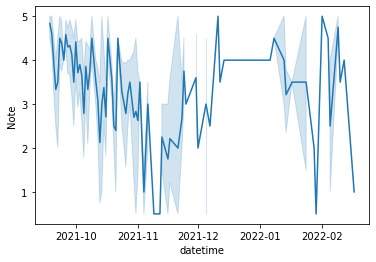

In [ ]:
sns.lineplot(df['datetime'],df['Note'])

>> Squid Game is basically ...

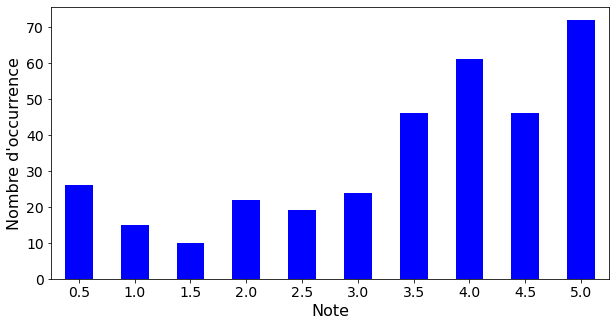

In [ ]:
plt.figure(figsize=(10,5))

df['Note'].value_counts().sort_index().plot(kind='bar', color='blue') # Thanks to Guillaume

plt.xticks(rotation=0, fontsize=14)

plt.yticks(fontsize=14)

plt.xlabel('Note', fontsize=16)

plt.ylabel('Nombre d\'occurrence', fontsize=16)

plt.show()

In [ ]:
df.key.value_counts()

0     23
1     23
2     23
3     23
4     23
5     23
6     23
7     23
8     23
9     23
10    23
11    23
12    23
13    22
14    20
Name: key, dtype: int64

# Preprocessing

## Lemmitizing function

In [ ]:
def lemmatize(corpus):
  """
  This is a function inspired (copier/coller) from TP of NLP
  It is simply a lemmatizing function
  """
  lemmatized_text = [token.lemma_ for token in corpus if (not token.is_punct) and (not token.is_stop) and (token.pos_ != 'SPACE') ]
  lemmatized_text = " ".join(lemmatized_text)

  return lemmatized_text

In [ ]:
french_stopwords = stopwords.words('french')

In [ ]:
elements_to_delete = ["ne","pas","mais"]

In [ ]:
for element in elements_to_delete:
  print(element)
  french_stopwords.remove(element)

ne
pas
mais


## Stemming function

In [ ]:
def stemm(corpus):
  """
  This is a function inspired (copier/coller) from TP of NLP
  It is simply a stemming function
  """
  stemmer = SnowballStemmer('french')
  #french_stopwords = stopwords.words('french')
  corpus = [token.text for token in corpus if (not token.is_punct) and 
                                               (not token.is_stop) and 
                                               (token.pos_ != 'SPACE') ]
  corpus = " ".join(corpus)
  corpus = [item for item in corpus.split(" ") if item not in french_stopwords]
  corpus = " ".join(corpus)
  preprocessed_corpus_tokenized = [stemmer.stem(token) for token in corpus.split(" ")]
  stemmed_corpus = " ".join(preprocessed_corpus_tokenized)
  return stemmed_corpus

In [ ]:
print(french_stopwords)

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'me', 'même', 'mes', 'moi', 'mon', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aurez', 'auront', 'aurai

In [ ]:
nlp = fr_core_news_md.load()

## Peprocess function

In [ ]:
def preprocess_text(corpus, lemmatizing=True) :
  corpus = corpus.lower().encode('utf-8').decode('utf-8')
  corpus = re.sub("\d+[h., ]?\d*", "", corpus)
  corpus = re.sub('[,\.!?(){}^-_:;/#""''``|]','',corpus)
  doc = nlp(corpus)
  if lemmatizing == True:
    preprocessed_corpus = lemmatize(doc)
  else:
    preprocessed_corpus = stemm(doc)
  return preprocessed_corpus

## The real show : Applying the previous functions

In [ ]:
df["corpus_preprocess"] = df["Description"].apply(lambda comment : preprocess_text(comment,lemmatizing=False))

In [ ]:
def tokenisation(comment):
  corpus_tokenized = nltk.word_tokenize(comment)
  return corpus_tokenized

In [ ]:
df["tokens"] = df["corpus_preprocess"].apply(lambda comment : tokenisation(comment))

In [ ]:
df[["corpus_preprocess", "tokens"]].head(1)

,corpus_preprocess,tokens
0,attend fin élabor clair début engag squid gam dénonc extrêm pauvret touch grand part popul désintérêt rich fac prolétair ru appât gain fair mis scen clinqu aguich œil jeux cour recr mortel ador concept personnag principal bon gar vrai vit piti second rôl attach ali remet retrouv mec busan oui réflex pet rôl épisod apog dramat ser squid gam idé vagu immens atout ser savoir fair retomb épisod train-train habituel film jeux sadiqu pouss group person entretu met nez personnag ultra-caricatural coupl truand foll élu personnag insupport ser vicieux fin moqu éperdu sort ami enfanc héros fin spoil saw revient twist savoir spoil créateur jeu cach mort rinc œil déroul épreuv déjà dem twist ser dévoil tôt spoil vieux gât veut paraîtr fin épisod personnag mort montr gros plan fac camer mis scen scen tuer agac avou interpel forc demi-surpris décept total revanch faill étrangl spectacl navr spoil vip masqu animal boul facet viennent fair paris gagn glouss plais mort ressembl lign directric ser dark netflix critiquent balourd impressionnent jeun ados rir amateur scénario fin fin laiss port saison netflix oblig trouv nécessair immédiat voir parvient prouv contrair sup saison dout suit préfer voir allianc joueur début squid gam déjou pieg tirent patt mesquin ultra-prévisibl film épouv commenc connaîtr retient héros vrai bon gar pauvr ali jeux déchir bill surpren premi mis scen original mec busan critiqu acerb societ épisod commencent chut vertigin besoin verr fauss tremp fin facil vu revu connaiss sag film épouv prévisibl you win saison gam over suit,"[attend, fin, élabor, clair, début, engag, squid, gam, dénonc, extrêm, pauvret, touch, grand, part, popul, désintérêt, rich, fac, prolétair, ru, appât, gain, fair, mis, scen, clinqu, aguich, œil, jeux, cour, recr, mortel, ador, concept, personnag, principal, bon, gar, vrai, vit, piti, second, rôl, attach, ali, remet, retrouv, mec, busan, oui, réflex, pet, rôl, épisod, apog, dramat, ser, squid, gam, idé, vagu, immens, atout, ser, savoir, fair, retomb, épisod, train-train, habituel, film, jeux, sadiqu, pouss, group, person, entretu, met, nez, personnag, ultra-caricatural, coupl, truand, foll, élu, personnag, insupport, ser, vicieux, fin, moqu, éperdu, sort, ami, enfanc, héros, fin, spoil, saw, revient, ...]"


In [ ]:
df["tokens"][0][:10]

['attend',
 'fin',
 'élabor',
 'clair',
 'début',
 'engag',
 'squid',
 'gam',
 'dénonc',
 'extrêm']

## Testing the Count function

---
<center >in this section I am searching to find the top 10 used words per documment ie per comment </center >

---


In [ ]:
count = Counter(df.tokens[0])
most_occur = count.most_common(10)
print(most_occur)

[('fin', 7), ('ser', 5), ('gam', 4), ('scen', 4), ('personnag', 4), ('épisod', 4), ('spoil', 4), ('squid', 3), ('fair', 3), ('mis', 3)]


In [ ]:
df['Naive_prediction'] = df['tokens'].apply(lambda x: 0 if any(e in x for e in ['ne', 'pas', 'mais', 'ni', 'jamais', 'guère', 'rien']) else 1)

In [ ]:
df[['sentiment']].value_counts()

sentiment
1            179
0            162
dtype: int64

---
> > Au total il y'a 179 commentaires classés comme positifs et 162 commentaire negatifs
---

> > > Total des commentaires est 341

---

In [ ]:
df[['Naive_prediction']].value_counts()

Naive_prediction
1                   339
0                     2
dtype: int64

>> la prediction naive ainsi developpé predit 339 commentaires comme positifs parmis les 341 du coup c'est grave

>> Le taux d'erreur est enorme

## Returning to pre-processing again

---
in this section I make a new variable (column) called 10_most_words containing the top used words in a comment 

--- 

In [ ]:
df['10_most_words'] = df['tokens'].apply(lambda x: Counter(x).most_common(10))

In [ ]:
df['10_most_words'].head()

0                     [(fin, 7), (ser, 5), (gam, 4), (scen, 4), (personnag, 4), (épisod, 4), (spoil, 4), (squid, 3), (fair, 3), (mis, 3)]
1             [(ser, 1), (sur-côt, 1), (prévisibl, 1), (idé, 1), (original, 1), (fin, 1), (vrai, 1), (mauvais, 1), (jeu, 1), (acteur, 1)]
2                  [(bout, 2), (fan, 1), (ser, 1), (coréen, 1), (général, 1), (dois, 1), (avou, 1), (scotch, 1), (incroi, 1), (cruel, 1)]
3                        [(ser, 3), (cré, 2), (terribl, 2), (bon, 2), (dison, 1), (suit, 1), (fan, 1), (an, 1), (product, 1), (asiat, 1)]
4    [(visuel, 1), (recherch, 1), (ludiqu, 1), (rythm, 1), (galer, 1), (personnag, 1), (intéress, 1), (jam, 1), (parfait, 1), (squid, 1)]
Name: 10_most_words, dtype: object

In [ ]:
df[df['sentiment']=='0']['10_most_words']

0              [(fin, 7), (ser, 5), (gam, 4), (scen, 4), (personnag, 4), (épisod, 4), (spoil, 4), (squid, 3), (fair, 3), (mis, 3)]
1      [(ser, 1), (sur-côt, 1), (prévisibl, 1), (idé, 1), (original, 1), (fin, 1), (vrai, 1), (mauvais, 1), (jeu, 1), (acteur, 1)]
5            [(bon, 3), (consomm, 2), (mauv, 2), (goût, 2), (show, 1), (fast, 1), (food, 1), (amateur, 1), (conced, 1), (papi, 1)]
7         [(horreur, 4), (gam, 4), (spectateur, 4), (jeux, 3), (fois, 3), (squid, 2), (réalist, 2), (cor, 2), (œuvr, 2), (ser, 2)]
8      [(ser, 3), (phénomen, 2), (pathet, 1), (rempl, 1), (moment, 1), (gor, 1), (intérêt, 1), (apport, 1), (scen, 1), (sangl, 1)]
                                                                  ...                                                             
323            [(ser, 3), (agit, 2), (gyakkyou, 2), (bur, 2), (kaij, 2), (écrir, 1), (roman, 1), (sérieil, 1), (pal, 1), (cop, 1)]
326         [(ser, 3), (long, 2), (franch, 1), (prendr, 1), (têt, 1), (rédig, 1), (

In [ ]:
list((1,5,2))

[1, 5, 2]

In [ ]:
for i in [('fin', 7), ('ser', 5), ('gam', 4), ('scen', 4)]:
  print(i)

('fin', 7)
('ser', 5)
('gam', 4)
('scen', 4)


In [ ]:
df['10_most_words'] = df['10_most_words'].apply(lambda x: [list(element)[0] for element in x])

In [ ]:
df['10_most_words'][0]

['fin',
 'ser',
 'gam',
 'scen',
 'personnag',
 'épisod',
 'spoil',
 'squid',
 'fair',
 'mis']

In [ ]:
df[df['sentiment']=='0'][['10_most_words','Note']].sort_values(by='Note')

,10_most_words,Note
162,"[vérit, navet, mot, exprim, point, ser, décept, longueur, anti, héros]",0.5
119,"[voir, impossibl, mettr, zéro, met, ser, certain, ado, +, jeun]",0.5
120,"[perdu, temp, nouvel, dis, sup, ser, moment, mal, jou, caricatural]",0.5
75,"[mauv, sort, jeu, acteur, vi, hung, gam, mal, jou, mod]",0.5
74,"[hontetres, danger, jeunessecomment, voul, enfant, aillent, genr, film, éton, jeuness]",0.5
...,...,...
277,"[symp, hât, voir, saison]",3.5
158,"[alic, borderland, meilleur, qualit, bon, saison, aiment, genr, ambianc, human]",3.5
146,"[ser, coréen, surpren, âme, sensibl, absten, violenc, laiss, prendr, jeu]",3.5
140,"[bon, agréabl, surpris, emball, premi, épisod, aim, histoir, original, concept]",3.5


In [ ]:
x = df.drop('sentiment',axis=1)

x = x.drop('Note', axis=1)

y = df['sentiment']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=4242)

In [ ]:
x_train.head(2)

,Description,key,good,bad,datetime,corpus_preprocess,tokens,Naive_prediction,10_most_words
146,Série Coréenne surprenante. Âmes sensibles s'abstenir tant les violences seront nombreuses. On se laisse prendre au jeu grâce au rythme et à la narration bien tournée. Quelques incohérences scénaristes gâchent la belle promesse,12,0,0,2021-10-04,ser coréen surpren âme sensibl absten violenc laiss prendr jeu grâc rythm narrat tourn incohérent scénar gâchent bel promess,"[ser, coréen, surpren, âme, sensibl, absten, violenc, laiss, prendr, jeu, grâc, rythm, narrat, tourn, incohérent, scénar, gâchent, bel, promess]",1,"[ser, coréen, surpren, âme, sensibl, absten, violenc, laiss, prendr, jeu]"
10,"petite pépite coréenne, une série prenante et attachante sur les personnages un scénario bien ficelé. le seul bémol la tenue des geôliers qui ressemble trop à celle de casa de papel",10,5,7,2021-09-25,petit pépit coréen ser pren attach personnag scénario ficel bémol tenu geôli ressembl cas papel,"[petit, pépit, coréen, ser, pren, attach, personnag, scénario, ficel, bémol, tenu, geôli, ressembl, cas, papel]",1,"[petit, pépit, coréen, ser, pren, attach, personnag, scénario, ficel, bémol]"


In [ ]:
all_negatives = [element for element in df[df['sentiment']=='0']['10_most_words']]

In [ ]:
#all_negatives = [element for element in x_train['10_most_words']]

In [ ]:
all_negatives

[['fin',
  'ser',
  'gam',
  'scen',
  'personnag',
  'épisod',
  'spoil',
  'squid',
  'fair',
  'mis'],
 ['ser',
  'sur-côt',
  'prévisibl',
  'idé',
  'original',
  'fin',
  'vrai',
  'mauvais',
  'jeu',
  'acteur'],
 ['bon',
  'consomm',
  'mauv',
  'goût',
  'show',
  'fast',
  'food',
  'amateur',
  'conced',
  'papi'],
 ['horreur',
  'gam',
  'spectateur',
  'jeux',
  'fois',
  'squid',
  'réalist',
  'cor',
  'œuvr',
  'ser'],
 ['ser',
  'phénomen',
  'pathet',
  'rempl',
  'moment',
  'gor',
  'intérêt',
  'apport',
  'scen',
  'sangl'],
 ['ser',
  'plupart',
  'vu',
  'battl',
  'royal',
  'final',
  'centain',
  'particip',
  'intel',
  'laiss'],
 ['ser',
  'engou',
  'human',
  'déshumanis',
  'don',
  'envi',
  'comprendr',
  'sud-coréen',
  'lanc',
  'visionnag'],
 ['épisod',
  'not',
  'attend',
  'trouv',
  'fin',
  'personnag',
  'scénario',
  'vois',
  'suspen',
  'ser'],
 ['faibl',
  'idé',
  'épisod',
  'scénario',
  'interpret',
  'réalis',
  'correct',
  'faut',
 

In [ ]:
import itertools

In [ ]:
all_negatives_ = []
# for element in all_negatives:
#   all_negatives+=element

In [ ]:
all_negatives_ = list(itertools.chain.from_iterable(all_negatives))

In [ ]:
all_negatives_ = list(set(all_negatives_))

In [ ]:
len(all_negatives_)

681

In [ ]:
all_negatives_

['morn',
 'personnel',
 'perm',
 'goutsbeaucoup',
 'doublag',
 'artist',
 'ancré',
 'world',
 'décid',
 'majeur',
 'an',
 'intoler',
 'proi',
 'original',
 'biensur',
 'aim',
 'mettent',
 'simplist',
 'papel',
 'personnag',
 'sais',
 'eau',
 'exam',
 'not',
 'effect',
 'intrigu',
 'moment',
 'pur',
 'surf',
 'charismat',
 'émotionnel',
 'envi',
 'américain',
 'scénarist',
 'pleurent',
 'produir',
 'teas',
 'saw',
 'voit',
 'vo',
 'x',
 'enchaîn',
 'nouveaut',
 'entraîn',
 'fait',
 'correct',
 'arriv',
 'côt',
 'éton',
 'version',
 'surévalu',
 'logiqu',
 'ambianc',
 'surcôt',
 'bas',
 'réal',
 'quoion',
 'milieu',
 'dévoil',
 'hât',
 'uniqu',
 'budget',
 'intérêt',
 'propos',
 'découvr',
 'indigent',
 'idiot',
 'ensembl',
 'pied',
 'cré',
 'nullit',
 'similair',
 'étrang',
 'intel',
 'minimum',
 'netflix',
 'fin',
 'déconseil',
 'lourd',
 'parallel',
 'comprendr',
 'food',
 'bof',
 'plais',
 'état',
 'battl',
 'rich',
 'médi',
 'fol',
 'opinion',
 'tand',
 'déplais',
 'venu',
 'benêt',

In [ ]:
x_train['Naive_prediction'] = x_train['tokens'].apply(lambda x: 0 if any(e in x for e in all_negatives_[:100]) else 1)

In [ ]:
x_train[['Naive_prediction']].value_counts()

Naive_prediction
0                   204
1                    34
dtype: int64

In [ ]:
y_train.value_counts()

1    127
0    111
Name: sentiment, dtype: int64

In [ ]:
x_test['Naive_prediction'] = x_test['tokens'].apply(lambda x: "0" if any(e in x for e in all_negatives_[:10]) else "1")

In [ ]:
x_test[['Naive_prediction']].value_counts()

Naive_prediction
1                   97
0                    6
dtype: int64

In [ ]:
y_test.value_counts()

1    52
0    51
Name: sentiment, dtype: int64

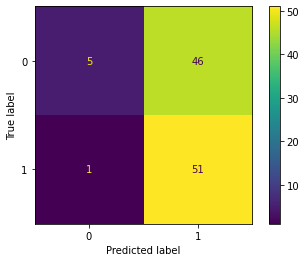

In [ ]:
y_test_predict = x_test[['Naive_prediction']]
cm = confusion_matrix(y_test, y_test_predict)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

plt.show()

# TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
x_train.columns

Index(['Description', 'key', 'good', 'bad', 'datetime', 'corpus_preprocess',
       'tokens', 'Naive_prediction', '10_most_words'],
      dtype='object')

In [ ]:
tfidf= TfidfVectorizer()
x_train_tfidf = tfidf.fit_transform([" ".join(words) for words in x_train['tokens']])

In [ ]:
labels_tfidf = tfidf.get_feature_names_out()

In [ ]:
x_test_tfidf = tfidf.transform([" ".join(words) for words in x_test['tokens']])

In [ ]:
x_train_tfidf.shape

(238, 2775)

In [ ]:
labels_tfidf.shape

(2775,)

In [ ]:
df_tfidf_train = pd.DataFrame(x_train_tfidf.toarray(), columns=labels_tfidf)

In [ ]:
df_tfidf_train.head()

,abandon,abattr,abdul,abim,abord,abordel,about,abri,abscon,absenc,...,évident,évit,évolu,évoqu,êre,être,île,œil,œuvr,œuvresc
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.090544,0.0,0.0,0.0,0.0,0.0,0.0,0.079692,...,0.0,0.0,0.079692,0.0,0.0,0.0,0.0,0.0,0.066996,0.0


In [ ]:
df_tfidf_train['sentiment'] = y_train

In [ ]:
df_tfidf_train['sentiment'].value_counts()

1    90
0    74
Name: sentiment, dtype: int64

In [ ]:
df_tfidf_train.head()

,abandon,abattr,abdul,abim,abord,abordel,about,abri,abscon,absenc,...,évit,évolu,évoqu,êre,être,île,œil,œuvr,œuvresc,sentiment
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,NaN
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,NaN
4,0.0,0.0,0.090544,0.0,0.0,0.0,0.0,0.0,0.0,0.079692,...,0.0,0.079692,0.0,0.0,0.0,0.0,0.0,0.066996,0.0,NaN


In [ ]:
df_best_word = df_tfidf_train.groupby(['sentiment']).sum()

In [ ]:
df_best_word_transposed = df_best_word.T

In [ ]:
df_best_word_transposed.head()

sentiment,0,1
abandon,0.123824,0.000000
abattr,0.000000,0.107702
abdul,0.000000,0.000000
abim,0.000000,0.190562
abord,0.000000,0.145177


In [ ]:
df_best_word_transposed.describe()

sentiment,0,1
count,2775.000000,2775.000000
mean,0.153845,0.166779
std,0.289461,0.327153
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.073206,0.044669
75%,0.203127,0.210212
max,6.031425,6.984554


In [ ]:
word_neg = df_best_word_transposed.iloc[:,0].sort_values(ascending=False).head(150)

In [ ]:
word_pos = df_best_word_transposed.iloc[:,1].sort_values(ascending=False).head(150)

In [ ]:
word_tri = [word for word in word_neg.index if word not in word_pos.index]

In [ ]:
y_test_predict = x_test['tokens'].apply(lambda x: '0' if any(e in x for e in word_tri) else '1')

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_test, y_test_predict)

array([[36, 15],
       [41, 11]])

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

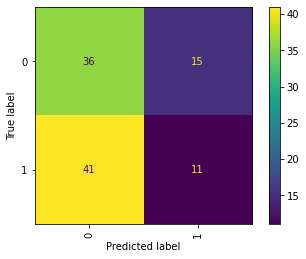

In [ ]:
cm = confusion_matrix(y_test, y_test_predict)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(xticks_rotation='vertical')

plt.show()

# Saison 2

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = CountVectorizer()
corpus = x_train['tokens'].apply(lambda x: " ".join(x))
x_train_vectorized = vectorizer.fit_transform(corpus)
corpus_2 = x_test['tokens'].apply(lambda x: " ".join(x))
x_test_vectorized = vectorizer.transform(corpus_2)


## Model BernoulliNB

In [ ]:
from sklearn.naive_bayes import BernoulliNB

In [ ]:
model = BernoulliNB()
model.fit(x_train_vectorized, y_train)


BernoulliNB()

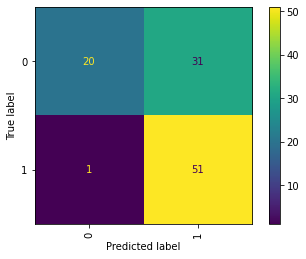

In [ ]:
y_test_predict = model.predict(x_test_vectorized)
cm = confusion_matrix(y_test, y_test_predict)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(xticks_rotation='vertical')

plt.show()

In [ ]:
print(classification_report(y_test,y_test_predict))

              precision    recall  f1-score   support

           0       0.95      0.39      0.56        51
           1       0.62      0.98      0.76        52

    accuracy                           0.69       103
   macro avg       0.79      0.69      0.66       103
weighted avg       0.79      0.69      0.66       103



## MultinomialNB

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
model_2 = BernoulliNB()
model_2.fit(x_train_vectorized, y_train)

BernoulliNB()

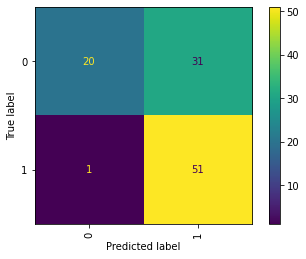

In [ ]:
y_test_predict = model_2.predict(x_test_vectorized)
cm = confusion_matrix(y_test, y_test_predict)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(xticks_rotation='vertical')

plt.show()

In [ ]:
print(classification_report(y_test,y_test_predict))

              precision    recall  f1-score   support

           0       0.95      0.39      0.56        51
           1       0.62      0.98      0.76        52

    accuracy                           0.69       103
   macro avg       0.79      0.69      0.66       103
weighted avg       0.79      0.69      0.66       103



## GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB

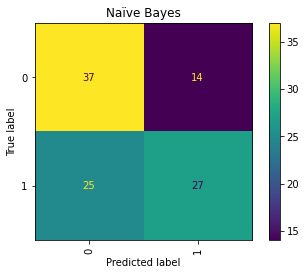

In [ ]:
model_3 = GaussianNB()
model_3.fit(x_train_vectorized.toarray(), y_train)
y_test_predict = model_3.predict(x_test_vectorized.toarray())
cm = confusion_matrix(y_test, y_test_predict)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(xticks_rotation='vertical')
plt.title('Naïve Bayes')
plt.show()